# GCN on Census
There is an example of using a GCN on a tabular dataset for binary classification (here, Census to detect the people earning > $50_000). We suppose we already have some **logically consistent arrows** (coming from logical analysis of data -> all the coherent DAGs), that we want the GCN to learn - **phase 2** . 

**Causal hierarchy** could be introduced in the [definition of neighbors](https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/loader/neighbor_loader.html#NeighborLoader) to build the subgraphs (i.e. batches of DataLoader)? 

Maybe: to specify the different "relations", we need to build a [heterogeneous graph](https://github.com/pyg-team/pytorch_geometric/blob/master/examples/hetero/to_hetero_mag.py)? 
Begin with these constraints:
    - Graph data 1: edge "sex"
    - Graph data 2: edge "work -> hours of work"
    - Graph data 1 -> (inherits from; temporal?) Graph data 2

In this notebook, we inspect **in which way a tabular dataset as Census can be used by an AI based on graphs to estimate wealthiness of individuals**. 

Therefore, we proceed in 2 steps:

**1. We prepare data to be handled by a model based on a graph**
We transform them into a graph, that involves strong assumptions on the features involved in connections...

**2. We train an AI based on graphs**
Here, we begin with a Graphical Neural Network (GNN) based on a Multi-Layer Perceptron (MLP), requiring the library Torch.

**3. We inspect if the graph-based AI indeed reflects common & expert knowledge on**
In particular, regarding the non-sense of certain inferences that should absolutely be avoided (e.g. education may influence occupation, but not the reverse).

## Enforcing causal paths in tabular GNN - Full data-graph (x, edge_index) child knowledge

To train a GNN while respecting a minimal set of causal paths, we pass to the GNN 2 types of graph-data:
- ancestor: with only the ancestor nodes
- child: ancestor + child nodes, adding as an edge "ancestor -> child"

-> s.t. child(n) becomes the ancestor of child(n+1)

Constitute 2 graph-data parent/child, suggesting causality by adding child nodes (and also edge: parent -> child) in the child data.

For the moment, we specify only 1 parent per edge, on 2 layers:
- ancestor layer: age -> occupation
- child layer: occupation -> hours of work per week

For the moment, to avoid spurious correlations we also keep only the ancestor features (age, sex, race, native country) as node features for all graph-data. Based on this ancestor "blind knowledge", add the child as node features (and also edge: parent -> child) in the child graph-data?

# Data preparation 

Causal analysis: before train&valid/test split, we reduced the number of features to contain only "straightforward" causal information -> enabling to integrate it progressively in our GNN (through edges). Therefore, we use factor analysis:

To control for the balance of df across classes, we sort the clients so that X gets perfect equality in the repartition of classes 0 and 1 (at the cost of 25 000 instead of the 45 000 initial individuals).

In [1]:
# choice of the "balanced" (small) / "unbalanced" (larger) dataset
dataset_balance = True

In [2]:
# imports and train/test split (to be put in part 2. of the notebook)
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import torch

try:
    import torch_geometric
except ModuleNotFoundError:
    TORCH = torch.__version__.split("+")[0]
    CUDA = "cu" + torch.version.cuda.replace(".","")
!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
#!pip install torch-geometric
#import torch_geometric

import sys
sys.path.append("../")

import time
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

import torch

import numpy as np
import pandas as pd

from classif_basic.data_preparation import handle_cat_features

from classif_basic.graph.data_to_graph import table_to_graph, add_new_edge
from classif_basic.graph.train import train_GNN_ancestor

# preparing the dataset on clients for binary classification
data = fetch_openml(data_id=1590, as_frame=True)

X = data.data
Y = (data.target == '>50K') * 1

SEED = 7
VALID_SIZE = 0.15
preprocessing_cat_features = "label_encoding"

X = handle_cat_features(X=X, preprocessing_cat_features=preprocessing_cat_features)

# first of all, unify features with "redundant" causal information
from classif_basic.graph.utils import get_unified_col

X = get_unified_col(X=X, list_cols_to_join = ["education","education-num"], new_col_name = "education")
X = get_unified_col(X=X, list_cols_to_join = ["relationship","marital-status"], new_col_name = "relationship")
X = get_unified_col(X=X, list_cols_to_join = ["occupation","workclass"], new_col_name = "job")
X = get_unified_col(X=X, list_cols_to_join = ["capital-gain","capital-loss"], new_col_name = "capital")

# select equal proportion of classes "wealthy" and "not wealthy", and generates the new dataset accordingly
from classif_basic.graph.utils import get_balanced_df

balanced_df = get_balanced_df(X=X, Y=Y)

if dataset_balance == True:

    X_balanced = balanced_df.drop("target", axis=1)
    Y_balanced = balanced_df["target"]

    X=X_balanced # here, we try with the whole dataset (assuming it is imbalanced, but counts almost 50 000 nodes)
    Y=Y_balanced

# then, normalize the df categories for better neural-network computation
from classif_basic.graph.utils import normalize_df

X=normalize_df(df=X, normalization='min_max')

# Split valid set for early stopping & model selection
# "stratify=Y" to keep the same proportion of target classes in train/valid (i.e. model) and test sets 
X_model, X_test, Y_model, Y_test = train_test_split(
    X, Y, test_size=VALID_SIZE, random_state=SEED, stratify=Y
)

Looking in links: https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Looking in links: https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
nb_max_true_positive: 11687
nb_max_true_negative: 37155
New nb indivs with true negative: 11687
11687
Number of individuals (balanced_df): 23374


# Data to ancestor & child Graphs 

Cascade de causes...

In [ ]:
# or form other types of graph-data, edge by edge (1 edge parent -> 1 edge child...)

from classif_basic.graph.data_to_graph import get_parent_child_data

list_data_total = []
dict_data_total = {}

list_first_ancestors = ['race', 'sex', 'native-country', 'age']

list_successive_paths=["education" , "relationship", "hours-per-week"]

for i in range(len(list_successive_paths)):
    edge_parent = list_successive_paths[i]
    print(f"\n {edge_parent}")
    data_total = get_parent_child_data(X=X_model, Y=Y_model, list_node_features=list_first_ancestors, 
                                                edge_parent=edge_parent)
    list_data_total.append(data_total)
    dict_data_total[f"{edge_parent}"] = data_total
    print(data_total)

In [ ]:
 # also load a graph-data with all the features and only one edge, for comparison with a "classic" GNN
data_full_education = get_parent_child_data(X=X_model, Y=Y_model, list_node_features=X_model.columns, 
                                                edge_parent="education")

data_full_relationship = get_parent_child_data(X=X_model, Y=Y_model, list_node_features=X_model.columns, 
                                                edge_parent="relationship")

# for comparison with a model where the features are combined (not added successively)
edge_parent="education"
edge_child="relationship"
dict_data_total[f"{edge_parent},{edge_child}"] = get_parent_child_data(X=X_model, Y=Y_model, list_node_features=list_first_ancestors, 
                                                edge_parent=edge_parent, edge_child=edge_child)

# Train a basic Graph Neural Network on the graph-shaped data

## Train with batches (neighborhood sampling) a basic GCN 

Here, we try using the batches constituted from neighborhoods to train the GNN, using our GPU (if accessed).

We use our GCN_ancestor class progressively adding through layers the "causal child" information:

Here with batches of 128 individuals, 76% of accuracy is reached by passing a causal order on layer1 and layer2 (accuracy == to the situation where all features are specified, and no causal layer!)...

We get here our own data-loader, ensuring that each batch passes the same individuals to the GNN (s.t. only causal data changes through layers):

We begin with all successive 3 edges (without fnlwgt, not enough info in edge_index?) given in our (basic) GCN with successive causal layers:

In [3]:
# test of the LAF model -> TODO learn how to aggregate each data?

loader_method="index_groups"
model_type="conv"#"sequential"
loss_name="CrossEntropyLoss"
#batch_size=1000#19_868
learning_rate = 0.01
nb_batches=10
epoch_nb = 200
cv_step=1000 # if cv_step < epoch_nb: no stop with cross-validation

skip_connection=True

In [ ]:
gnn_attention = train_GNN_ancestor(
                list_data_total=[
                    dict_data_total['education'],
                    dict_data_total['relationship']],
                # [data_full_education_relationship] for single info (correlated != causal channel)
                model_type=model_type,
                loader_method=loader_method,
                loss_name=loss_name,
                #batch_size=batch_size,
                nb_batches=nb_batches,
                epoch_nb = epoch_nb,
                cv_step=cv_step,
                learning_rate = learning_rate,
                skip_connection=skip_connection)

# observation: saturation at a high loss (vs simple GCN layers) when LAF-inspired based method is used...
# TODO learn layers aggregation weights directly through their output-loss? 
# // attention in each sub-GNN, would make sense...

Comparison with a classic GNN with one edge *combining* the information (education, relationship) added iteratively above (still with ancestor node features) 

In [ ]:
gnn_attention_combined = train_GNN_ancestor(
                list_data_total=[
                    dict_data_total["education,relationship"]],
                # [data_full_education_relationship] for single info (correlated != causal channel)
                model_type=model_type,
                loader_method=loader_method,
                loss_name=loss_name,
                #batch_size=batch_size,
                nb_batches=nb_batches,
                epoch_nb = epoch_nb,
                cv_step=cv_step,
                learning_rate = learning_rate,
                skip_connection=skip_connection)

# Non-Sense directed edges, for comparison
Education->relationship (vs) relationship->education ; to see if the iterative architecture is as performant as when causal childs follow their parents... 

I.e. inspect impact of the non-sense: absurd sense of the causal ancestorship

Else: integrates the information as in a pure combination?

In [4]:
from classif_basic.graph.data_to_graph import get_parent_child_data

list_first_ancestors = ['race', 'sex', 'native-country', 'age']

dict_data_total = {}

In [5]:
dict_data_total['education'] = get_parent_child_data(X=X_model, Y=Y_model, list_node_features=list_first_ancestors, 
                                                edge_parent="education")

In [6]:
# create the structure of data-graph to pass to the edge "native-country"
# (this feature was previously only in node features with age, sex, and race, as a 1st-order ancestor)
dict_data_total['relationship'] = get_parent_child_data(X=X_model, Y=Y_model, list_node_features=list_first_ancestors, 
                                                edge_parent="relationship")

In [7]:
loader_method="index_groups"
model_type="conv"#"sequential"
loss_name="CrossEntropyLoss"
#batch_size=1000#19_868
learning_rate = 0.01
nb_batches=10
epoch_nb = 200
cv_step=1000 # if cv_step < epoch_nb: no stop with cross-validation

skip_connection=True

In [ ]:
gnn_attention_non_sense = train_GNN_ancestor(
                list_data_total=[
                    dict_data_total['relationship'],
                    dict_data_total['education']],
                # [data_full_education_relationship] for single info (correlated != causal channel)
                model_type=model_type,
                loader_method=loader_method,
                loss_name=loss_name,
                #batch_size=batch_size,
                nb_batches=nb_batches,
                epoch_nb = epoch_nb,
                cv_step=cv_step,
                learning_rate = learning_rate,
                skip_connection=skip_connection)

In [13]:
from collections import defaultdict

In [14]:
def merge_listed_results_in_dict(list_results):

    dd = defaultdict(list)

    for d in list_results: # you can list as many input dicts as you want here
        for key, value in d.items():
            dd[key].append(value)
        
    return dd

In [21]:
# test the stability of the model for non-sense causal order relationship -> education 

epoch_nb=10
nb_same_model_experiments=100

list_results_train = []
list_results_valid = []
list_training_time = []

for i in range(nb_same_model_experiments):
    print(f"Model {i} \n \n ")
    training_time, results_train, results_valid = train_GNN_ancestor(
                    list_data_total=[
                        dict_data_total['relationship'],
                        dict_data_total['education']],
                    # [data_full_education_relationship] for single info (correlated != causal channel)
                    model_type=model_type,
                    loader_method=loader_method,
                    loss_name=loss_name,
                    #batch_size=batch_size,
                    nb_batches=nb_batches,
                    epoch_nb = epoch_nb,
                    cv_step=cv_step,
                    learning_rate = learning_rate,
                    skip_connection=skip_connection)
    
    list_results_train.append(results_train)
    list_results_valid.append(results_valid)
    list_training_time.append(training_time)
    
dict_results_train = merge_listed_results_in_dict(list_results_train)
dict_results_valid = merge_listed_results_in_dict(list_results_valid)
# dict_training_time = merge_listed_results_in_dict(list_training_time)

Model 0 
 
 
Training no more improved over the past 1000 epochs

conv GNN model, Loader method index_groups on multiple graph-data
Training of the basic GCN on Census on 19867 nodes and 34970927 edges, 
 with 10 batches each of 1986 individuals and 7 epochs took 0 mn

||| Results of the GNN across epochs |||

||| Results of the GNN on the last epoch |||
Model 1 
 
 
Training no more improved over the past 1000 epochs

conv GNN model, Loader method index_groups on multiple graph-data
Training of the basic GCN on Census on 19867 nodes and 34970927 edges, 
 with 10 batches each of 1986 individuals and 9 epochs took 0 mn

||| Results of the GNN across epochs |||

||| Results of the GNN on the last epoch |||
Model 2 
 
 
Training no more improved over the past 1000 epochs

conv GNN model, Loader method index_groups on multiple graph-data
Training of the basic GCN on Census on 19867 nodes and 34970927 edges, 
 with 10 batches each of 1986 individuals and 6 epochs took 0 mn

||| Results of t

Training no more improved over the past 1000 epochs

conv GNN model, Loader method index_groups on multiple graph-data
Training of the basic GCN on Census on 19867 nodes and 34970927 edges, 
 with 10 batches each of 1986 individuals and 8 epochs took 0 mn

||| Results of the GNN across epochs |||

||| Results of the GNN on the last epoch |||
Model 25 
 
 

conv GNN model, Loader method index_groups on multiple graph-data
Training of the basic GCN on Census on 19867 nodes and 34970927 edges, 
 with 10 batches each of 1986 individuals and 10 epochs took 1 mn

||| Results of the GNN across epochs |||

||| Results of the GNN on the last epoch |||
Model 26 
 
 
Training no more improved over the past 1000 epochs

conv GNN model, Loader method index_groups on multiple graph-data
Training of the basic GCN on Census on 19867 nodes and 34970927 edges, 
 with 10 batches each of 1986 individuals and 7 epochs took 0 mn

||| Results of the GNN across epochs |||

||| Results of the GNN on the last e

Training no more improved over the past 1000 epochs

conv GNN model, Loader method index_groups on multiple graph-data
Training of the basic GCN on Census on 19867 nodes and 34970927 edges, 
 with 10 batches each of 1986 individuals and 10 epochs took 1 mn

||| Results of the GNN across epochs |||

||| Results of the GNN on the last epoch |||
Model 49 
 
 
Training no more improved over the past 1000 epochs

conv GNN model, Loader method index_groups on multiple graph-data
Training of the basic GCN on Census on 19867 nodes and 34970927 edges, 
 with 10 batches each of 1986 individuals and 8 epochs took 0 mn

||| Results of the GNN across epochs |||

||| Results of the GNN on the last epoch |||
Model 50 
 
 
Training no more improved over the past 1000 epochs

conv GNN model, Loader method index_groups on multiple graph-data
Training of the basic GCN on Census on 19867 nodes and 34970927 edges, 
 with 10 batches each of 1986 individuals and 7 epochs took 0 mn

||| Results of the GNN acr

Training no more improved over the past 1000 epochs

conv GNN model, Loader method index_groups on multiple graph-data
Training of the basic GCN on Census on 19867 nodes and 34970927 edges, 
 with 10 batches each of 1986 individuals and 9 epochs took 0 mn

||| Results of the GNN across epochs |||

||| Results of the GNN on the last epoch |||
Model 72 
 
 
Training no more improved over the past 1000 epochs

conv GNN model, Loader method index_groups on multiple graph-data
Training of the basic GCN on Census on 19867 nodes and 34970927 edges, 
 with 10 batches each of 1986 individuals and 4 epochs took 0 mn

||| Results of the GNN across epochs |||

||| Results of the GNN on the last epoch |||
Model 73 
 
 
Training no more improved over the past 1000 epochs

conv GNN model, Loader method index_groups on multiple graph-data
Training of the basic GCN on Census on 19867 nodes and 34970927 edges, 
 with 10 batches each of 1986 individuals and 6 epochs took 0 mn

||| Results of the GNN acro

Training no more improved over the past 1000 epochs

conv GNN model, Loader method index_groups on multiple graph-data
Training of the basic GCN on Census on 19867 nodes and 34970927 edges, 
 with 10 batches each of 1986 individuals and 7 epochs took 0 mn

||| Results of the GNN across epochs |||

||| Results of the GNN on the last epoch |||
Model 95 
 
 
Training no more improved over the past 1000 epochs

conv GNN model, Loader method index_groups on multiple graph-data
Training of the basic GCN on Census on 19867 nodes and 34970927 edges, 
 with 10 batches each of 1986 individuals and 5 epochs took 0 mn

||| Results of the GNN across epochs |||

||| Results of the GNN on the last epoch |||
Model 96 
 
 
Training no more improved over the past 1000 epochs

conv GNN model, Loader method index_groups on multiple graph-data
Training of the basic GCN on Census on 19867 nodes and 34970927 edges, 
 with 10 batches each of 1986 individuals and 10 epochs took 1 mn

||| Results of the GNN acr

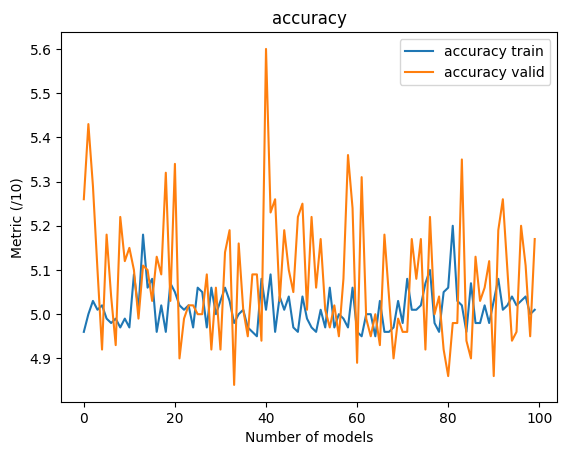

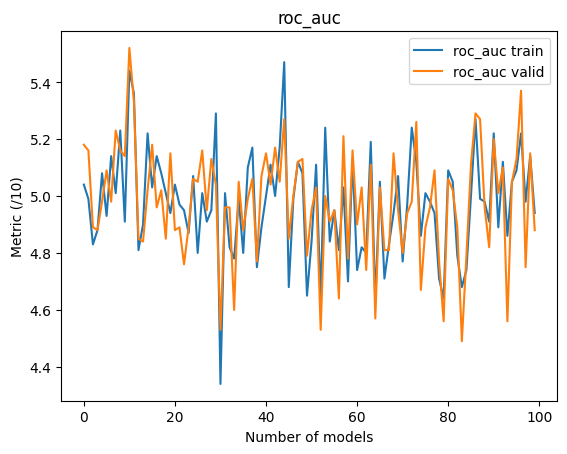

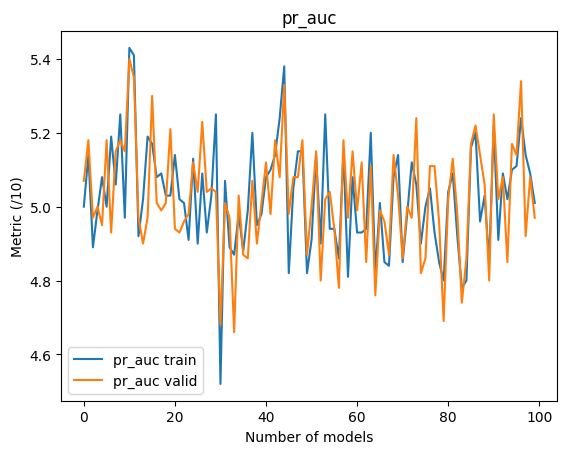

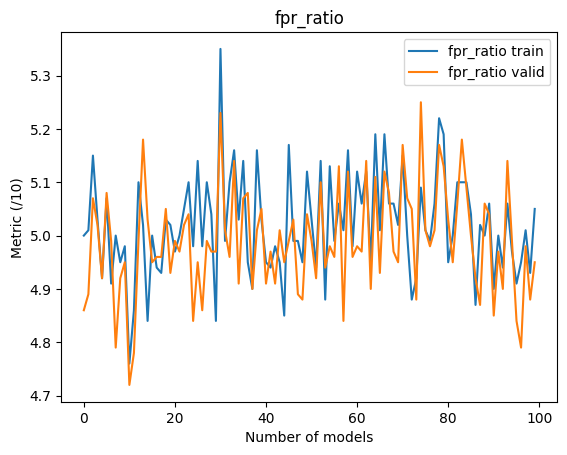

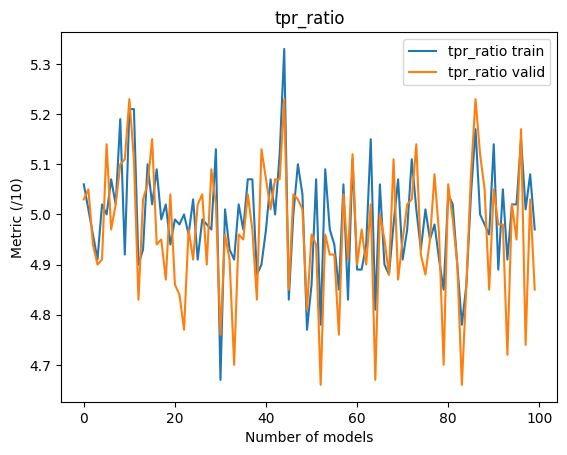

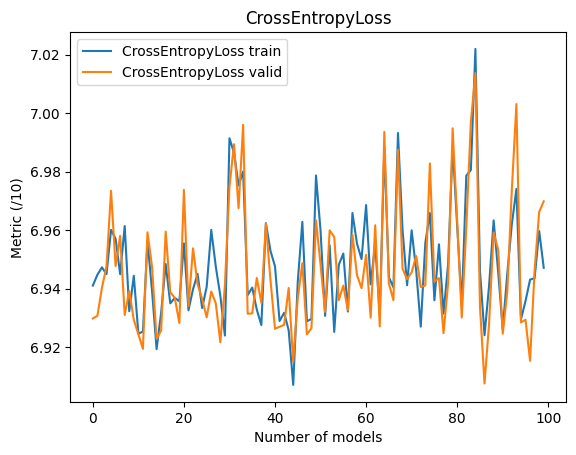

In [22]:
import matplotlib.pylab as plt

for metric_train, metric_valid in zip(dict_results_train.keys(), dict_results_valid.keys()):
    
    if metric_train==metric_valid: 
        plt.title(f"{metric_train}")
        plt.plot(dict_results_train[metric_train], label=f"{metric_train} train")
        plt.plot(dict_results_valid[metric_valid], label=f"{metric_valid} valid")
        plt.xlabel("Number of models")
        plt.ylabel("Metric (/10)")
        plt.legend()
        plt.show()

In [9]:
# test the stability of the model for causal order education -> relationship

epoch_nb=10
nb_same_model_experiments=100

list_results_train = []
list_results_valid = []
list_training_time = []

for i in range(nb_same_model_experiments):
    print(f"Model {i} \n \n ")
    training_time, results_train, results_valid = train_GNN_ancestor(
                    list_data_total=[
                        dict_data_total['education'],
                        dict_data_total['relationship']],
                    # [data_full_education_relationship] for single info (correlated != causal channel)
                    model_type=model_type,
                    loader_method=loader_method,
                    loss_name=loss_name,
                    #batch_size=batch_size,
                    nb_batches=nb_batches,
                    epoch_nb = epoch_nb,
                    cv_step=cv_step,
                    learning_rate = learning_rate,
                    skip_connection=skip_connection)
    
    list_results_train.append(results_train)
    list_results_valid.append(results_valid)
    list_training_time.append(training_time)
    
dict_results_train = merge_listed_results_in_dict(list_results_train)
dict_results_valid = merge_listed_results_in_dict(list_results_valid)
# dict_training_time = merge_listed_results_in_dict(list_training_time)

Model 0 
 
 

conv GNN model, Loader method index_groups on multiple graph-data
Training of the basic GCN on Census on 19867 nodes and 60845968 edges, 
 with 10 batches each of 1986 individuals and 10 epochs took 1 mn

||| Results of the GNN across epochs |||

||| Results of the GNN on the last epoch |||
Model 1 
 
 

conv GNN model, Loader method index_groups on multiple graph-data
Training of the basic GCN on Census on 19867 nodes and 60845968 edges, 
 with 10 batches each of 1986 individuals and 10 epochs took 0 mn

||| Results of the GNN across epochs |||

||| Results of the GNN on the last epoch |||
Model 2 
 
 

conv GNN model, Loader method index_groups on multiple graph-data
Training of the basic GCN on Census on 19867 nodes and 60845968 edges, 
 with 10 batches each of 1986 individuals and 10 epochs took 0 mn

||| Results of the GNN across epochs |||

||| Results of the GNN on the last epoch |||
Model 3 
 
 

conv GNN model, Loader method index_groups on multiple graph-data
Tr


conv GNN model, Loader method index_groups on multiple graph-data
Training of the basic GCN on Census on 19867 nodes and 60845968 edges, 
 with 10 batches each of 1986 individuals and 10 epochs took 0 mn

||| Results of the GNN across epochs |||

||| Results of the GNN on the last epoch |||
Model 28 
 
 

conv GNN model, Loader method index_groups on multiple graph-data
Training of the basic GCN on Census on 19867 nodes and 60845968 edges, 
 with 10 batches each of 1986 individuals and 10 epochs took 1 mn

||| Results of the GNN across epochs |||

||| Results of the GNN on the last epoch |||
Model 29 
 
 

conv GNN model, Loader method index_groups on multiple graph-data
Training of the basic GCN on Census on 19867 nodes and 60845968 edges, 
 with 10 batches each of 1986 individuals and 10 epochs took 1 mn

||| Results of the GNN across epochs |||

||| Results of the GNN on the last epoch |||
Model 30 
 
 

conv GNN model, Loader method index_groups on multiple graph-data
Training of 


conv GNN model, Loader method index_groups on multiple graph-data
Training of the basic GCN on Census on 19867 nodes and 60845968 edges, 
 with 10 batches each of 1986 individuals and 10 epochs took 1 mn

||| Results of the GNN across epochs |||

||| Results of the GNN on the last epoch |||
Model 55 
 
 

conv GNN model, Loader method index_groups on multiple graph-data
Training of the basic GCN on Census on 19867 nodes and 60845968 edges, 
 with 10 batches each of 1986 individuals and 10 epochs took 0 mn

||| Results of the GNN across epochs |||

||| Results of the GNN on the last epoch |||
Model 56 
 
 

conv GNN model, Loader method index_groups on multiple graph-data
Training of the basic GCN on Census on 19867 nodes and 60845968 edges, 
 with 10 batches each of 1986 individuals and 10 epochs took 0 mn

||| Results of the GNN across epochs |||

||| Results of the GNN on the last epoch |||
Model 57 
 
 

conv GNN model, Loader method index_groups on multiple graph-data
Training of 


conv GNN model, Loader method index_groups on multiple graph-data
Training of the basic GCN on Census on 19867 nodes and 60845968 edges, 
 with 10 batches each of 1986 individuals and 10 epochs took 1 mn

||| Results of the GNN across epochs |||

||| Results of the GNN on the last epoch |||
Model 82 
 
 

conv GNN model, Loader method index_groups on multiple graph-data
Training of the basic GCN on Census on 19867 nodes and 60845968 edges, 
 with 10 batches each of 1986 individuals and 10 epochs took 0 mn

||| Results of the GNN across epochs |||

||| Results of the GNN on the last epoch |||
Model 83 
 
 

conv GNN model, Loader method index_groups on multiple graph-data
Training of the basic GCN on Census on 19867 nodes and 60845968 edges, 
 with 10 batches each of 1986 individuals and 10 epochs took 1 mn

||| Results of the GNN across epochs |||

||| Results of the GNN on the last epoch |||
Model 84 
 
 

conv GNN model, Loader method index_groups on multiple graph-data
Training of 

NameError: name 'defaultdict' is not defined

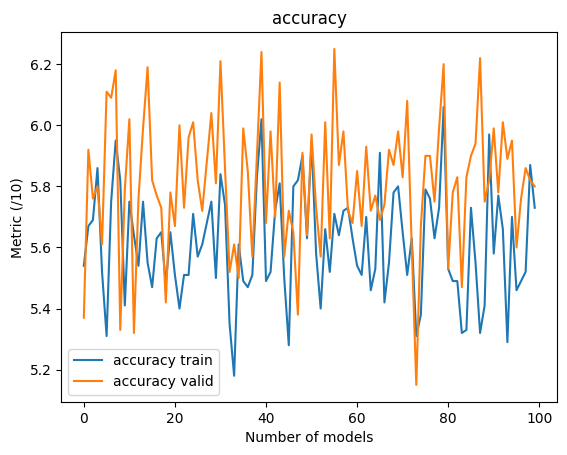

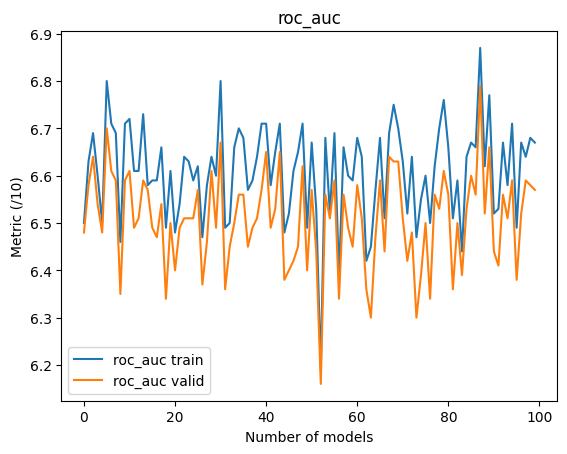

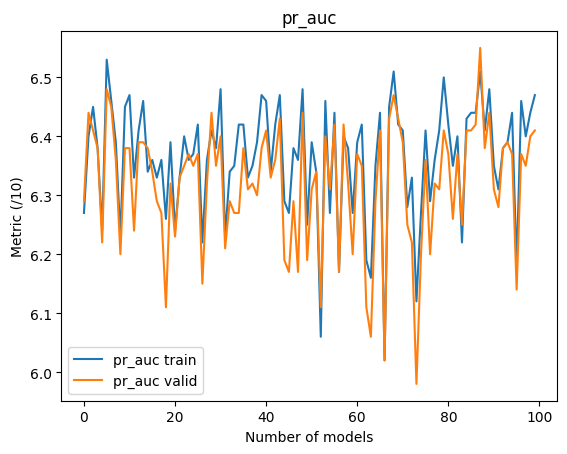

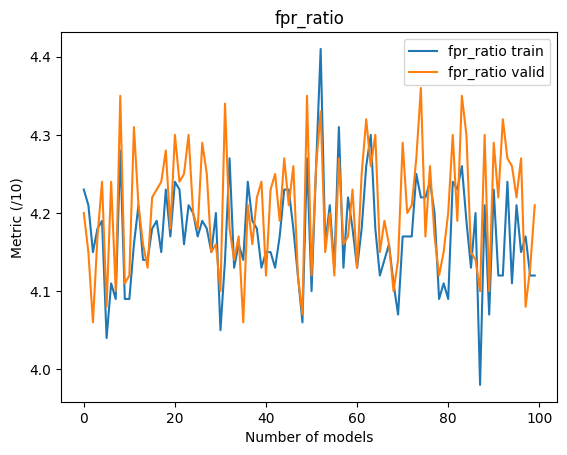

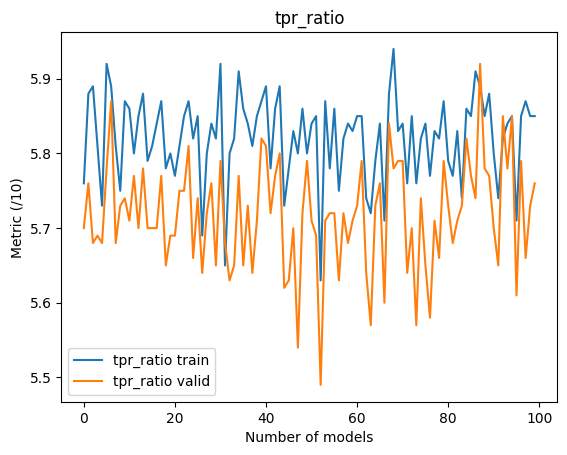

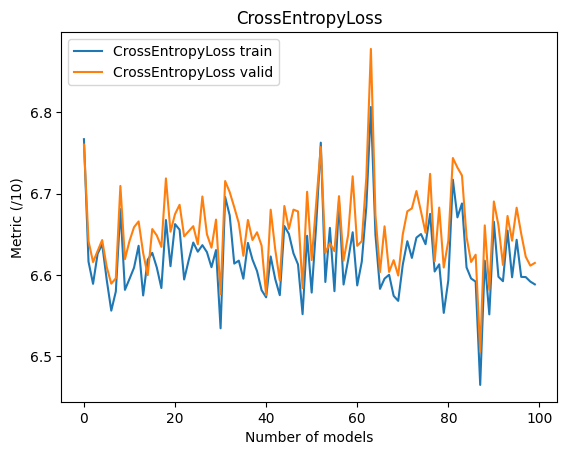

In [17]:
import matplotlib.pylab as plt

for metric_train, metric_valid in zip(dict_results_train.keys(), dict_results_valid.keys()):
    
    if metric_train==metric_valid: 
        plt.title(f"{metric_train}")
        plt.plot(dict_results_train[metric_train], label=f"{metric_train} train")
        plt.plot(dict_results_valid[metric_valid], label=f"{metric_valid} valid")
        plt.xlabel("Number of models")
        plt.ylabel("Metric (/10)")
        plt.legend()
        plt.show()

Pure combination of the features (no edge order), for comparison:

In [18]:
dict_data_total['education, relationship'] = get_parent_child_data(X=X_model, Y=Y_model, list_node_features=list_first_ancestors, 
                                                edge_parent="education", edge_child="relationship")

In [19]:
epoch_nb=10
nb_same_model_experiments=100

list_results_train = []
list_results_valid = []
list_training_time = []

for i in range(nb_same_model_experiments):
    print(f"Model {i} \n \n ")
    training_time, results_train, results_valid = train_GNN_ancestor(
                    list_data_total=[
                        dict_data_total['education, relationship'],
                        ],
                    # [data_full_education_relationship] for single info (correlated != causal channel)
                    model_type=model_type,
                    loader_method=loader_method,
                    loss_name=loss_name,
                    #batch_size=batch_size,
                    nb_batches=nb_batches,
                    epoch_nb = epoch_nb,
                    cv_step=cv_step,
                    learning_rate = learning_rate,
                    skip_connection=skip_connection)
    
    list_results_train.append(results_train)
    list_results_valid.append(results_valid)
    list_training_time.append(training_time)
    
dict_results_train = merge_listed_results_in_dict(list_results_train)
dict_results_valid = merge_listed_results_in_dict(list_results_valid)
#dict_training_time = merge_listed_results_in_dict(list_training_time)

Model 0 
 
 

conv GNN model, Loader method index_groups on unique graph-data
Training of the basic GCN on Census on 19867 nodes and 10967444 edges, 
 with 10 batches each of 1986 individuals and 10 epochs took 0 mn

||| Results of the GNN across epochs |||

||| Results of the GNN on the last epoch |||
Model 1 
 
 

conv GNN model, Loader method index_groups on unique graph-data
Training of the basic GCN on Census on 19867 nodes and 10967444 edges, 
 with 10 batches each of 1986 individuals and 10 epochs took 0 mn

||| Results of the GNN across epochs |||

||| Results of the GNN on the last epoch |||
Model 2 
 
 

conv GNN model, Loader method index_groups on unique graph-data
Training of the basic GCN on Census on 19867 nodes and 10967444 edges, 
 with 10 batches each of 1986 individuals and 10 epochs took 0 mn

||| Results of the GNN across epochs |||

||| Results of the GNN on the last epoch |||
Model 3 
 
 

conv GNN model, Loader method index_groups on unique graph-data
Training o


conv GNN model, Loader method index_groups on unique graph-data
Training of the basic GCN on Census on 19867 nodes and 10967444 edges, 
 with 10 batches each of 1986 individuals and 10 epochs took 0 mn

||| Results of the GNN across epochs |||

||| Results of the GNN on the last epoch |||
Model 28 
 
 

conv GNN model, Loader method index_groups on unique graph-data
Training of the basic GCN on Census on 19867 nodes and 10967444 edges, 
 with 10 batches each of 1986 individuals and 10 epochs took 0 mn

||| Results of the GNN across epochs |||

||| Results of the GNN on the last epoch |||
Model 29 
 
 
Training no more improved over the past 1000 epochs

conv GNN model, Loader method index_groups on unique graph-data
Training of the basic GCN on Census on 19867 nodes and 10967444 edges, 
 with 10 batches each of 1986 individuals and 10 epochs took 0 mn

||| Results of the GNN across epochs |||

||| Results of the GNN on the last epoch |||
Model 30 
 
 

conv GNN model, Loader method in

Training no more improved over the past 1000 epochs

conv GNN model, Loader method index_groups on unique graph-data
Training of the basic GCN on Census on 19867 nodes and 10967444 edges, 
 with 10 batches each of 1986 individuals and 9 epochs took 0 mn

||| Results of the GNN across epochs |||

||| Results of the GNN on the last epoch |||
Model 53 
 
 

conv GNN model, Loader method index_groups on unique graph-data
Training of the basic GCN on Census on 19867 nodes and 10967444 edges, 
 with 10 batches each of 1986 individuals and 10 epochs took 0 mn

||| Results of the GNN across epochs |||

||| Results of the GNN on the last epoch |||
Model 54 
 
 
Training no more improved over the past 1000 epochs

conv GNN model, Loader method index_groups on unique graph-data
Training of the basic GCN on Census on 19867 nodes and 10967444 edges, 
 with 10 batches each of 1986 individuals and 9 epochs took 0 mn

||| Results of the GNN across epochs |||

||| Results of the GNN on the last epoch |

Training no more improved over the past 1000 epochs

conv GNN model, Loader method index_groups on unique graph-data
Training of the basic GCN on Census on 19867 nodes and 10967444 edges, 
 with 10 batches each of 1986 individuals and 7 epochs took 0 mn

||| Results of the GNN across epochs |||

||| Results of the GNN on the last epoch |||
Model 78 
 
 

conv GNN model, Loader method index_groups on unique graph-data
Training of the basic GCN on Census on 19867 nodes and 10967444 edges, 
 with 10 batches each of 1986 individuals and 10 epochs took 0 mn

||| Results of the GNN across epochs |||

||| Results of the GNN on the last epoch |||
Model 79 
 
 
Training no more improved over the past 1000 epochs

conv GNN model, Loader method index_groups on unique graph-data
Training of the basic GCN on Census on 19867 nodes and 10967444 edges, 
 with 10 batches each of 1986 individuals and 7 epochs took 0 mn

||| Results of the GNN across epochs |||

||| Results of the GNN on the last epoch |

AttributeError: 'int' object has no attribute 'items'

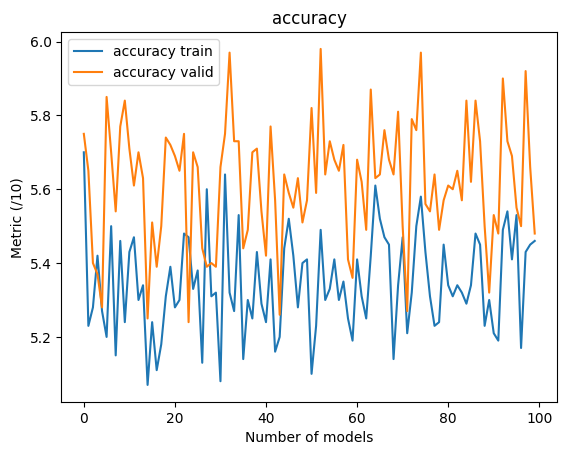

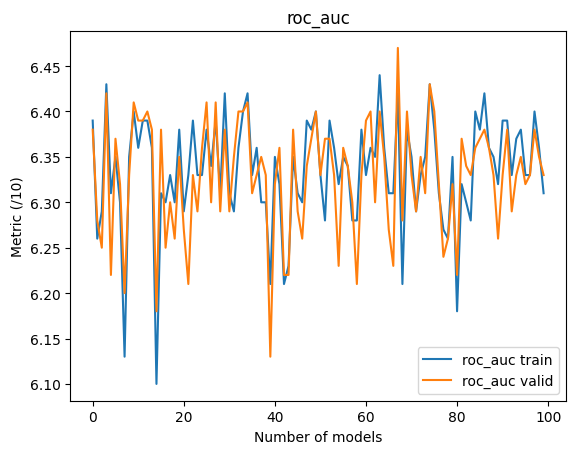

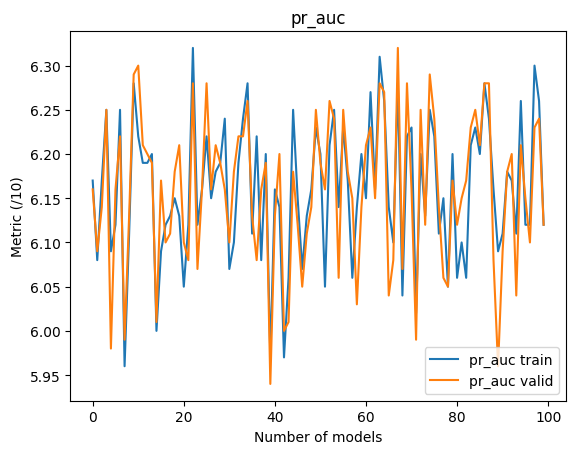

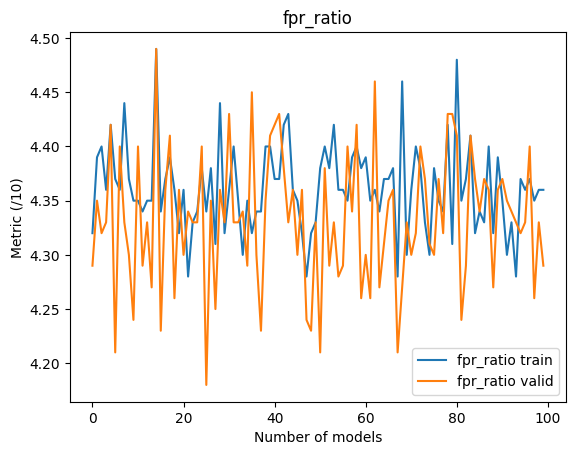

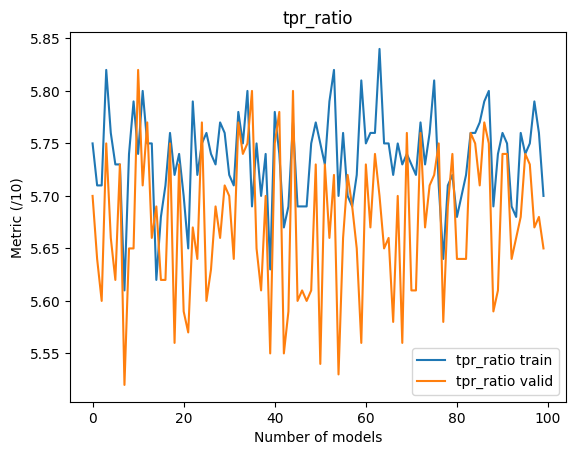

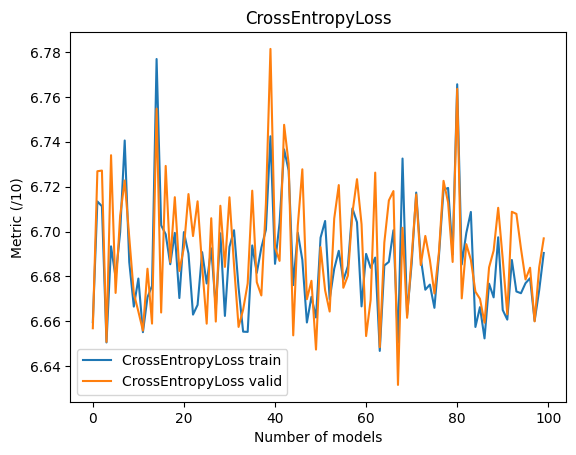

In [20]:
import matplotlib.pylab as plt

for metric_train, metric_valid in zip(dict_results_train.keys(), dict_results_valid.keys()):
    
    if metric_train==metric_valid: 
        plt.title(f"{metric_train}")
        plt.plot(dict_results_train[metric_train], label=f"{metric_train} train")
        plt.plot(dict_results_valid[metric_valid], label=f"{metric_valid} valid")
        plt.xlabel("Number of models")
        plt.ylabel("Metric (/10)")
        plt.legend()
        plt.show()

# Basic XGB for comparison - excellent results
With the same unified features 92% ROC-AUC, 81-84% PR-AUC, 85% accuracy on train&valid sets.

(!) My method: adapt the [decision tree](https://www.kaggle.com/code/fareselmenshawii/decision-tree-from-scratch#Model-Implementation) & [random forests](https://www.kaggle.com/code/fareselmenshawii/random-forest-from-scratch#Model-Implementation) algorithms 

To delete the causal ancestor (n-1) features, when splitting on a child (n) feature...

In [ ]:
list_first_ancestors

In [ ]:
list_successive_paths

Scenario 1: only splits between ancestors (and other childs condamned to split on themselves...) -> 18% FPR, 76%TPR (only 2% loss)!

Scenario 1: splits between ancestors 'age', 'sex', 'race', 'native-country'
    And 'relationship', 'education'&'relationship'...
    Idea: relationship has to be splitted alone or with education ; but how to set the order education->relationship >> at the moment, only combination of the features? 
    
TODO: on the 2nd order ancestors, delete the features corresponding to 1st ancestors ; and apply the decision tree to them...

In [ ]:
#interaction_constraints = [[0, 2], [1, 3, 4], [5, 6]]
interaction_constraints = [list_first_ancestors, 
                           #['relationship'], 
                           #['education', 'relationship'],
                           #['relationship', 'job', 'hours-per-week']
                          ]

In [ ]:
from classif_basic.graph.train import train_xgb_benchmark

X_train, X_valid, Y_train, Y_valid = train_test_split(
    X_model, Y_model, test_size=VALID_SIZE, random_state=SEED, stratify=Y_model
)

xgb_constrained = train_xgb_benchmark(X_train=X_train, X_valid=X_valid, Y_train=Y_train, Y_valid=Y_valid, 
                    interaction_constraints=interaction_constraints)

Now, plot the decision trees to see in which sense the simplest causal hierarchy (here, of 1st ancestors -> other features) is respected:

In [ ]:
from classif_basic.model_analysis import plot_tree, get_df_first_splits

booster = xgb_constrained
get_max_split_feature=False
nb_min_trees = 6 #None

df_first_splits = get_df_first_splits(booster=booster, 
                                      get_max_split_feature=get_max_split_feature,
                                      nb_min_trees=nb_min_trees)
df_first_splits

In [ ]:
list_description_trees = booster.get_booster().get_dump()

for tree_relationship_idx in df_first_splits['trees_index'][1]:
    print(list_description_trees[tree_relationship_idx])
    print()

In [ ]:
num_trees = 3

list_description_trees = booster.get_booster().get_dump()

first_split = list_description_trees[num_trees].split('[')[1]
first_feature = first_split.split(']')[0]

In [ ]:
list_description_trees[42]

In [ ]:
first_splitting_feature = df_first_splits.index[0]

print(f"first_splitting_feature: {first_splitting_feature}")

for num_trees in df_first_splits["trees_index"][first_splitting_feature]:
    
    plot_tree(
        booster=xgb_constrained,
        num_trees=num_trees)

In [ ]:
train_xgb_benchmark(X_train=X_train, X_valid=X_valid, Y_train=Y_train, Y_valid=Y_valid, 
                    interaction_constraints=None)

TODO after sequential aggregation model, tests on graph-data constituted with X_test!

# Results on test set

We observe a stability in the results of the model trained with full features (even if only 1 edge) - approximately 75% accuracy and 75% ROC-AUC. 

By contrast, the model trained with 2 edges generalizes less well on unbalanced data it has never seen. The change of indexes across layers may perturbate the straightforward GCN more than "improve its knowledge", thus we have to seek for a **new progressive causal architecture**. 

## Models trained on balanced data
### Unbalanced (7000 individuals)

In [ ]:
# load already formed graph-data, to gain time
from classif_basic.model import pickle_load_model
from classif_basic.graph.plot import plot_perfs_gnn

dict_test = pickle_load_model("/work/data/graph_data/unbalanced/test/dict_all_edges.pkl")

data_full_test = pickle_load_model("/work/data/graph_data/unbalanced/test/data_full_features_education_relationship.pkl")

In [ ]:
# also load the model, to gain time 
gcn_classic_small = pickle_load_model("/work/data/models/gcn_classic_education_relationship.pkl")

gcn_ancestor_small = pickle_load_model("/work/data/models/gcn_ancestor_education_relationship_job.pkl")

In [ ]:
plot_perfs_gnn(classifier=gcn_classic_small,
               list_data_test=[data_full_test])

In [ ]:
[dict_test[link] for link in dict_test.keys()]

In [ ]:
plot_perfs_gnn(classifier=gcn_ancestor_small,
               list_data_test=[dict_test[link] for link in dict_test.keys()])

### Balanced (3500 individuals)

In [ ]:
dict_test_balanced = pickle_load_model("/work/data/graph_data/balanced/test/dict_all_edges.pkl")

data_full_test_balanced = pickle_load_model("/work/data/graph_data/balanced/test/data_full_features_education_relationship.pkl")

plot_perfs_gnn(classifier=gcn_classic_small,
               list_data_test=[data_full_test_balanced])

In [ ]:
plot_perfs_gnn(classifier=gcn_ancestor_small,
               list_data_test=[dict_test_balanced[link] for link in dict_test_balanced.keys()])

## Model trained on full (unbalanced) data 

For comparison, we show here the results of the "classic" model, hence expected more performant (as the index information is not perturbated across layers), on test data.

Even if the accuracy is low on balanced data, it show almost equal (but **a bit lower**) performances than the classic model trained on balanced data. This encourages us to **continue with these (series of?) 1-edge classifiers**...

### Unbalanced (7000 individuals)

In [ ]:
# load the model, to gain time 
gcn_classic_large = pickle_load_model("/work/data/models/gcn_classic_education_relationship_45_000_indivs.pkl")

plot_perfs_gnn(classifier=gcn_classic_large,
               list_data_test=[data_full_test])

### Balanced (3500 individuals)

In [ ]:
plot_perfs_gnn(classifier=gcn_classic_large,
               list_data_test=[data_full_test_balanced])